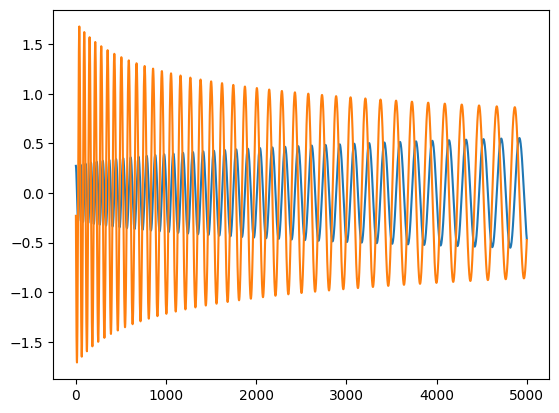

In [234]:
import numpy as np
import matplotlib.pyplot as plt

def L_schedule(t, L0=1.0, dL=0.5, t0=40.0, alpha=0.05):
    # smooth drift using tanh
    return L0 + 1.5 * dL * (1.0 + alpha * (t - t0))
    #return L0 - 0.5 * dL * (1.0 + np.tanh(alpha * (t - t0)))

def step_pendulum(theta, omega, t, dt, g=9.8, c=0.1, L0=1.0, dL=0.5, t0=40.0, alpha=0.05):
    def f(th, om, tt):
        L = L_schedule(tt, L0=L0, dL=dL, t0=t0, alpha=alpha)
        dth = om
        dom = -(g / L) * np.sin(th) #- c * om
        return dth, dom

    k1 = f(theta, omega, t)
    k2 = f(theta + 0.5*dt*k1[0], omega + 0.5*dt*k1[1], t + 0.5*dt)
    k3 = f(theta + 0.5*dt*k2[0], omega + 0.5*dt*k2[1], t + 0.5*dt)
    k4 = f(theta + dt*k3[0], omega + dt*k3[1], t + dt)

    theta_next = theta + dt*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6.0
    omega_next = omega + dt*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6.0

    theta_next = (theta_next + np.pi) % (2*np.pi) - np.pi
    return theta_next, omega_next

def simulate_pendulum_drifting_L(N=5002, dt=0.02, seed=0,
                                 g=9.8, c=0.1, L0=1.0, dL=0.5, t0=40.0, alpha=0.05):
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-1.0, 1.0)
    omega = rng.uniform(-0.5, 0.5)

    X = np.zeros((N, 2))
    t = 0.0
    for k in range(N):
        X[k] = [theta, omega]
        theta, omega = step_pendulum(theta, omega, t, dt, g=g, c=c, L0=L0, dL=dL, t0=t0, alpha=alpha)
        t += dt
    return X
X = simulate_pendulum_drifting_L()
plt.plot(X[:, 0])
plt.plot(X[:, 1])

In [237]:
from KernelEDMD import OnlineKernelEDMD as kEDMD
from scipy.spatial.distance import pdist

M = 2500
N = 2
X_train = X[:M, :] # 0-{M-1}
Y_train = X[1:M+1, :] # 1-M
X_update = X[M:-2, :] # {M-1}:4997
Y_update = X[M+1:-1, :] # M:4998
valid = X[M+2:, :] #{M+1}: 4999
print(X_update.shape)
print(Y_update.shape)
print(valid.shape)
pair_d2 = pdist(X_train.T, 'sqeuclidean')
#sigma = np.sqrt(np.median(pair_d2) / np.log(X_train.shape[1]))
sigma = np.sqrt(1.5)
kedmd = kEDMD(X_train.T, Y_train.T, kernel="gaussian", eps=sigma)
#kedmd = kEDMD(X_train.T, Y_train.T, kernel="polynomial", c=20, p=5)
kedmd.fit(thr=1e-3)
print("fit done")

kedmd_fixed = copy.deepcopy(kedmd)

(2500, 2)
(2500, 2)
(2500, 2)
fit done


In [280]:
pred = X[M+1, :]
preds_fixed = []
errors_fixed = []
for i in range(valid.shape[0]):
    pred = kedmd_fixed.predict(pred)
    preds_fixed.append(pred)
    err = valid[i] - pred
    errors_fixed.append(err)
preds_fixed = np.array(preds_fixed)
errors_fixed = np.array(errors_fixed)

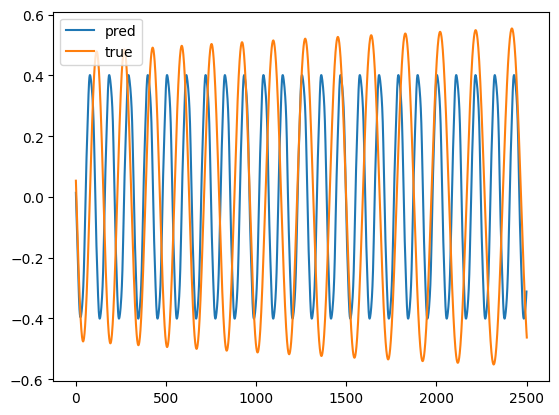

In [264]:
#plt.plot(preds_fixed[:, 0], preds_fixed[:, 1], label="pred")
#plt.plot(X[M:, 0], X[M:,1], label="true")
#plt.plot(X[:M, 0], X[:M, 1], label="train")
plt.plot(preds_fixed[:, 0], label="pred")
plt.plot(X[M:, 0], label="true")
plt.legend()
plt.show()

In [309]:
preds_1_step = []
errors = []
for i in range(valid.shape[0]):
    new_x = X_update[i, :]
    new_y = Y_update[i, :]
    pred_1_step = kedmd.predict(new_y)
    
    preds_1_step.append(pred_1_step)
    err = valid[i] - pred_1_step
    errors.append(err)
preds_1_step = np.array(preds_1_step)
errors = np.array(errors)

(2500,)


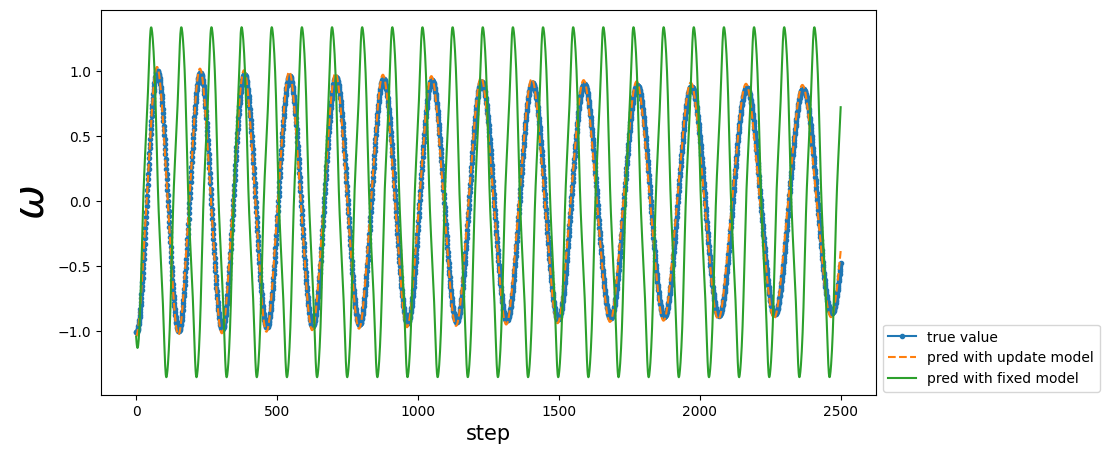

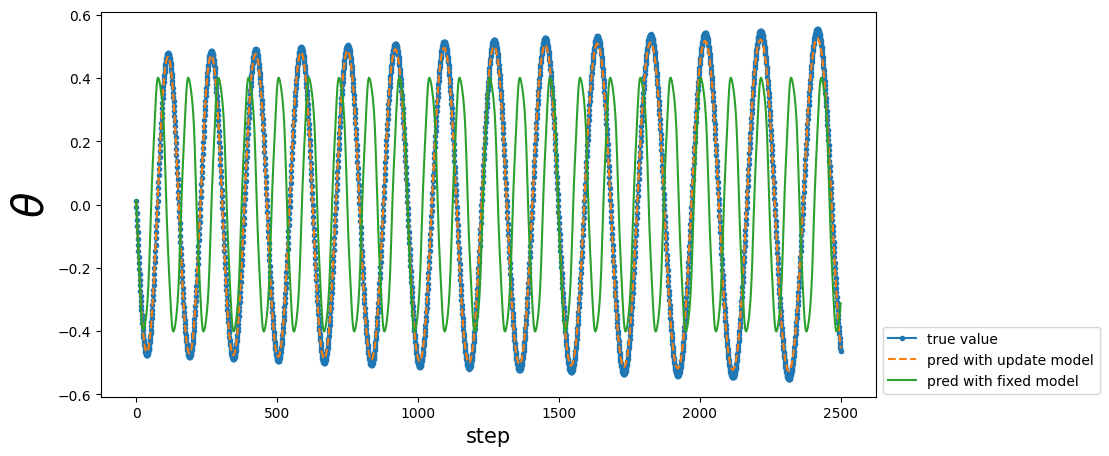

In [343]:
print(preds_1_step[:, 0].shape)
# plt.scatter(0, Y_update[1][0])
plt.figure(figsize=(10, 5))
plt.plot(valid[:, 1], ".-", label="true value")
plt.plot(preds_1_step[:, 1], "--", label="pred with update model")
plt.plot(preds_fixed[:, 1], "-", label="pred with fixed model")
plt.xlabel("step", size=15)
plt.ylabel(r"$\omega$", size=30)
plt.legend(bbox_to_anchor=(1.0, 0.2), loc='upper left')
plt.figure(figsize=(10, 5))
plt.plot(valid[:, 0], ".-", label="true value")
plt.plot(preds_1_step[:, 0], "--", label="pred with update model")
plt.plot(preds_fixed[:, 0], "-", label="pred with fixed model")
plt.xlabel("step", size=15)
plt.ylabel(r"$\theta$", size=30)
plt.legend(bbox_to_anchor=(1.0, 0.2), loc='upper left')
plt.show()

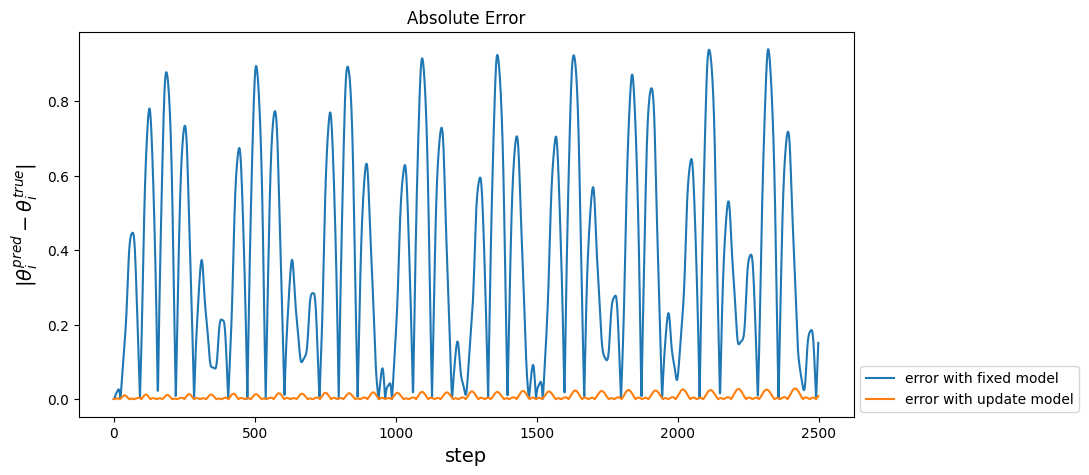

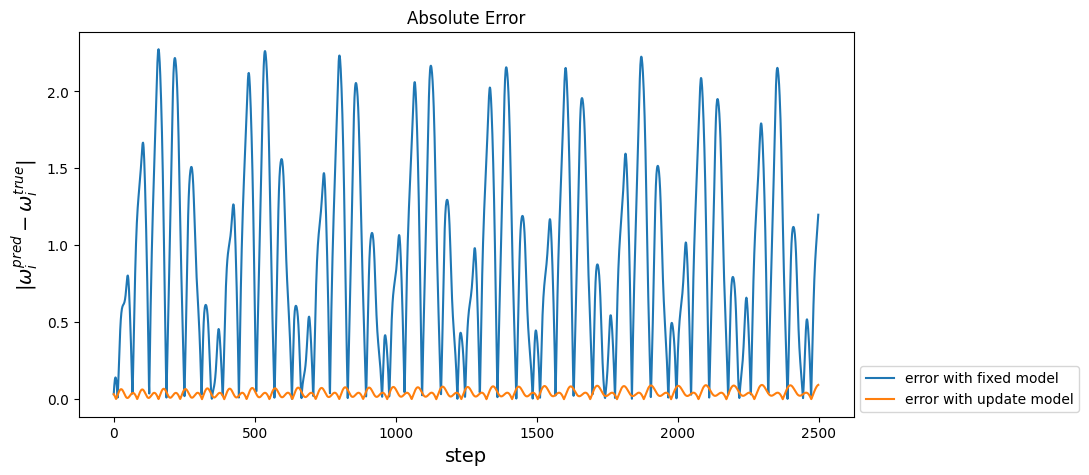

In [360]:
plt.figure(figsize=(10, 5))
plt.plot(np.abs(errors_fixed[:, 0]), label="error with fixed model")
plt.plot(np.abs(errors[:, 0]), label="error with update model")
plt.xlabel("step", size=14)
plt.ylabel(r"$|\theta^{pred}_i - \theta^{true}_i|$", size=14)
plt.title("Absolute Error")
plt.legend(bbox_to_anchor=(1.0, 0.15), loc='upper left')
plt.figure(figsize=(10, 5))
plt.plot(np.abs(errors_fixed[:, 1]), label="error with fixed model")
plt.plot(np.abs(errors[:, 1]), label="error with update model")
plt.xlabel("step", size=14)
plt.ylabel(r"$|\omega^{pred}_i - \omega^{true}_i|$", size=14)
plt.title("Absolute Error")
plt.legend(bbox_to_anchor=(1.0, 0.15), loc='upper left')
plt.show()